# 経済関係のデータセット

景気ウォッチャー調査：景気に敏感な職種の人々へのインタビュー結果を集計した「街角景気」<br>
https://www5.cao.go.jp/keizai3/watcher/watcher_menu.html

![Watcher](slides/watcher.png)

- 合計のところの値が、全体の指数 (DI: Diffusion Index)

日経平均株価<br>
https://indexes.nikkei.co.jp/nkave/historical/nikkei_stock_average_monthly_jp.csv
- ダウンロードして data フォルダ以下に置いてください

景気ウォッチャーDIと日経平均株価に相関があるか調べる。

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Excelファイルの読み込み
# - skiprows: 先頭行の読み飛ばし
# - usecols: 使用する列の指定
watcher = pd.read_excel('data/watcher5.xls', skiprows=range(0,3), usecols='B:D')
# 確認
watcher.head(3)

,Unnamed: 1,Unnamed: 2,合計
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,2002年,1.0,35.4


In [2]:
# 不要な2行の削除
df = watcher.drop([0, 1])

# 列インデックスの付け直し
df.columns = ['year', 'month', 'watcher']

# '年'の除去
df.year.replace('年', '', regex=True, inplace=True)
df.head(1)

,year,month,watcher
2,2002,1.0,35.4


In [3]:
# 行インデックスを年月の属性に置き換える
# 最初の年、月を取得、整数に変換
y = int(df.head(1).year)
m = int(df.head(1).month)

# 文字列に再変換 '2002-01'
start_date = '{}-{:02}'.format(y, m)

# 年月の区間を生成し、行インデックスとして指定
# - start: 開始日
# - freq: 間隔 'MS' 月間隔、月の最初の日
# - periods: 繰り返し回数
watcher_range = pd.date_range(start=start_date, freq='MS', periods=len(df))
df.index = watcher_range

# 不要な列の削除
df = df.drop(['year', 'month'], axis=1)

# 確認
df

,watcher
2002-01-01,35.4
2002-02-01,34.6
2002-03-01,41.4
2002-04-01,44.2
2002-05-01,45.2
...,...
2021-05-01,38.1
2021-06-01,47.6
2021-07-01,48.4
2021-08-01,34.7


<hr>

### 日経平均株価の読み込み

https://indexes.nikkei.co.jp/nkave/historical/nikkei_stock_average_monthly_jp.csv
- 配布資料には入っていませんので、ダウンロードして data フォルダ以下に置いてください

### 以下は説明のみ

- 実行は各自で行ってください

In [4]:
# 読み込んで確認
# - encoding: 日本語の文字コードを指定
stock = pd.read_csv('data/nikkei_stock_average_monthly_jp.csv', encoding='shift_jis')
stock.head(2)

,データ日付,終値,始値,高値,安値
0,2000/01/01,19539.70,19002.86,19539.70,18168.27
1,2000/02/01,19959.52,19423.38,20007.77,19367.83


In [5]:
# 末尾も確認
# - 株価以外の値が入っている
stock.tail(1)

,データ日付,終値,始値,高値,安値
263,月次データは、日次終値ベースで集計。月次データ日付は月初日。本資料は日経の著作物であり、本資...,NaN,NaN,NaN,NaN


In [6]:
# 処理できないデータの削除
stock = stock.drop(len(stock) - 1)
# 確認
stock.tail(1)

,データ日付,終値,始値,高値,安値
262,2021/11/01,29745.87,29647.08,29808.12,29106.78


In [7]:
# 'データ日付' を行インデックスとして指定
stock.index = pd.to_datetime(stock['データ日付'])
# 確認
stock

,データ日付,終値,始値,高値,安値
データ日付,,,,,
2000-01-01,2000/01/01,19539.70,19002.86,19539.70,18168.27
2000-02-01,2000/02/01,19959.52,19423.38,20007.77,19367.83
2000-03-01,2000/03/01,20337.32,20081.67,20706.65,19078.60
2000-04-01,2000/04/01,17973.70,20726.99,20833.21,17973.70
2000-05-01,2000/05/01,16332.45,18403.08,18439.36,16008.14
...,...,...,...,...,...
2021-07-01,2021/07/01,27283.59,28707.04,28783.28,27283.59
2021-08-01,2021/08/01,28089.54,27781.02,28089.54,27013.25
2021-09-01,2021/09/01,29452.66,28451.02,30670.10,28451.02


In [8]:
# 月ごとの'終値'を月の株価として、df に追加
df['stock'] = stock.loc[watcher_range]['終値']
# 確認
df

,watcher,stock
2002-01-01,35.4,9997.80
2002-02-01,34.6,10587.83
2002-03-01,41.4,11024.94
2002-04-01,44.2,11492.54
2002-05-01,45.2,11763.70
...,...,...
2021-05-01,38.1,28860.08
2021-06-01,47.6,28791.53
2021-07-01,48.4,27283.59
2021-08-01,34.7,28089.54


<AxesSubplot:ylabel='watcher'>

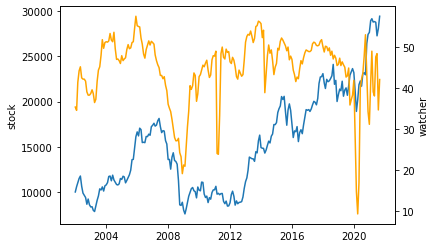

In [9]:
# 2つのスケールが異なるグラフを重ねたいため、描画エリアのオブジェクトを取得
fig, ax = plt.subplots()
# 最初のグラフを描画
sns.lineplot(data=df.stock, ax=ax)
# 2軸目の領域を取得
ax2 = ax.twinx()
# - ax: 2軸目を指定して、2つめのグラフを描画
sns.lineplot(data=df.watcher, ax=ax2, color='orange')